# Linear Models (Brownian + OU) for sanity check 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jr

import matplotlib.pyplot as plt
from flax import nnx

from src.sdes.examples import BrownianSDE, BrownianBridgeSDE, OUSDE
from src.sdes.base import AuxiliarySDE, GuidedBridgeSDE
from src.sdes.neural_bridge import NeuralBridge
from src.sdes.solver import SDESolver
from src.utils.trainer import train, load

In [3]:
rngs = nnx.Rngs(
    params=0,
    data=42
)

## Brownian Bridges

In [11]:
sde = BrownianSDE(
    dim=1,
    params={
        "mu": jnp.array([1.0]),
        "sigma": jnp.array([[1.0]])
    }
)

# A standard Brownian motion as the auxiliary SDE
aux_sde = AuxiliarySDE(
    dim=1,
    coeffs={
        "T": 1.0,
        "beta": lambda t: jnp.array([0.0]),
        "B": lambda t: jnp.array([[0.0]]),
        "a_tilde_0": None,
        "a_tilde_T": jnp.array([[1.0]])
    }
)

x0 = jnp.array([0.0])   # start point
vT = jnp.array([0.0])   # observation point
n_steps = 200           # number of time steps
ts = jnp.linspace(0., 1., n_steps+1, endpoint=True)
epsilon = 1e-5          # observation noise

guided_sde = GuidedBridgeSDE(
    sde, aux_sde,
    obs_params={
        "vT": vT,
        "LT": jnp.eye(1),   # fully observed
        "SigmaT": epsilon**2 * jnp.eye(1)
    },
    ts=ts,
    eq_type="uLM",          # u, L, M formulation of BIF ODE
)

b_fn = guided_sde.b
sigma_fn = guided_sde.sigma
G_fn = guided_sde.G

nn_config = {
    "model_name": "MLPSmall",
    "input_dim": 1,
    "output_dim": 1,
    "hidden_dims": (20, 20, 20),
    "act_type": "tanh",
    "norm_type": "none",
    "rngs": rngs
}

neural_bridge = NeuralBridge(
    b_fn, sigma_fn, G_fn, nn_config
)

train_config = {
    "ckpt_dir": "../assets/ckpts/neural_bridge/brownian",
    "lr": 1e-3,
    "batch_size": 20,
    "n_iters": 5000,
}

In [12]:
train(neural_bridge, x0, ts, train_config, rngs=rngs)

# or load the pretrained model
# load(neural_bridge, train_config["ckpt_dir"])

Step [  100 / 5000]: loss = 0.305412, Time: 0.563s
Step [  200 / 5000]: loss = 0.280328, Time: 0.164s
Step [  300 / 5000]: loss = 0.280726, Time: 0.155s
Step [  400 / 5000]: loss = 0.268020, Time: 0.158s
Step [  500 / 5000]: loss = 0.264763, Time: 0.157s
Step [  600 / 5000]: loss = 0.266852, Time: 0.156s
Step [  700 / 5000]: loss = 0.253481, Time: 0.153s
Step [  800 / 5000]: loss = 0.247086, Time: 0.154s
Step [  900 / 5000]: loss = 0.253115, Time: 0.154s
Step [ 1000 / 5000]: loss = 0.245287, Time: 0.152s
Step [ 1100 / 5000]: loss = 0.244211, Time: 0.155s
Step [ 1200 / 5000]: loss = 0.245267, Time: 0.155s
Step [ 1300 / 5000]: loss = 0.240732, Time: 0.155s
Step [ 1400 / 5000]: loss = 0.243076, Time: 0.156s
Step [ 1500 / 5000]: loss = 0.240437, Time: 0.151s
Step [ 1600 / 5000]: loss = 0.240839, Time: 0.153s
Step [ 1700 / 5000]: loss = 0.240773, Time: 0.163s
Step [ 1800 / 5000]: loss = 0.239635, Time: 0.175s
Step [ 1900 / 5000]: loss = 0.240338, Time: 0.164s
Step [ 2000 / 5000]: loss = 0.2

In [13]:
bridge_sde = BrownianBridgeSDE(
    dim=1,
    params={
        "mu": jnp.array([1.0]),
        "sigma": jnp.array([[1.0]]),
        "vT": vT,
        "T": 1.0
    }
)

In [14]:
neural_bridge.eval()
guided_solve = SDESolver(guided_sde)
nb_solve = SDESolver(neural_bridge)
bridge_solve = SDESolver(bridge_sde)

n_samples = 10

guided_traj = guided_solve.batch_solve(rngs.data(), x0, ts, n_samples)
nb_traj = nb_solve.batch_solve(rngs.data(), x0, ts, n_samples)
bridge_traj = bridge_solve.batch_solve(rngs.data(), x0, ts, n_samples)

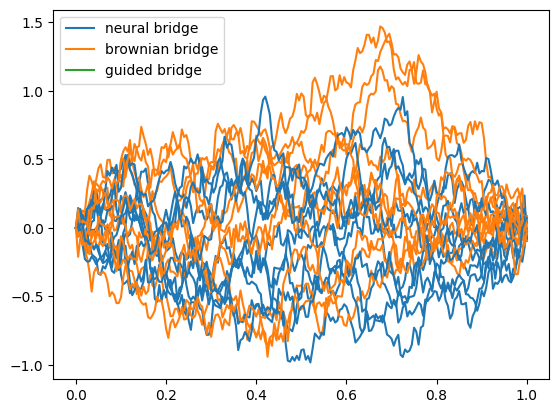

In [15]:
for i in range(n_samples):
    plt.plot(ts, nb_traj[i], color="tab:blue")
    plt.plot(ts, bridge_traj[i], color="tab:orange")
    # plt.plot(ts, guided_traj[i], color="tab:green")
    
plt.plot([], [], color="tab:blue", label="neural bridge")
plt.plot([], [], color="tab:orange", label="brownian bridge")
plt.plot([], [], color="tab:green", label="guided bridge")
plt.legend()
plt.show()